In [1]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt

# Modeling, selection, and evaluation
from fastai.text import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels

%matplotlib inline 

In [2]:
# Use seaborn for pairplot
!pip install seaborn

# Use some functions from tensorflow_docs
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-ina5pheu
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-ina5pheu
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0430fe3be375a1f3f6267b86300e1c0f1d79b2b26_-cp36-none-any.whl size=146357 sha256=07539850afbf1ddb27271d5cd291924b5628f3df5f466eebc3112128b18f729b
  Stored in directory: /tmp/pip-ephem-wheel-cache-rq0k2q3y/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.4.0


In [4]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Read file into dataframe
pd.set_option('display.max_colwidth', -1)
df = pd.read_csv('/content/drive/MyDrive/data/winequality.csv',sep=";")
df = df.reindex(np.random.permutation(df.index))  
df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
119,7.3,0.320,0.48,13.3,0.060,57.0,196.0,0.99820,3.04,0.50,9.2,5
1882,7.7,0.300,0.42,14.3,0.045,45.0,213.0,0.99910,3.18,0.63,9.2,5
3023,7.0,0.450,0.34,19.8,0.040,12.0,67.0,0.99760,3.07,0.38,11.0,6
4660,6.6,0.330,0.41,2.0,0.027,14.0,79.0,0.99063,3.27,0.63,12.4,6
2630,5.9,0.445,0.26,1.4,0.027,23.0,109.0,0.99148,3.30,0.36,10.5,6


In [7]:
train_dataset = df.sample(frac=0.8,random_state=0)
test_dataset = df.drop(train_dataset.index)

In [8]:
train_stats = train_dataset.describe()
train_stats.pop("quality")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
fixed acidity,3918.0,6.863451,0.835928,3.90000,6.30000,6.800000,7.4000,14.2000
volatile acidity,3918.0,0.277764,0.099183,0.08000,0.21000,0.260000,0.3200,1.0050
citric acid,3918.0,0.335521,0.119438,0.00000,0.27000,0.320000,0.3900,1.6600
residual sugar,3918.0,6.388017,5.040021,0.60000,1.70000,5.100000,9.9000,31.6000
chlorides,3918.0,0.045906,0.022104,0.00900,0.03600,0.043000,0.0500,0.3460
free sulfur dioxide,3918.0,35.143951,16.570467,3.00000,23.00000,33.000000,45.0000,146.5000
total sulfur dioxide,3918.0,138.212098,42.025875,9.00000,108.00000,134.000000,167.0000,366.5000
density,3918.0,0.994038,0.002925,0.98722,0.99176,0.993755,0.9961,1.0103
pH,3918.0,3.188420,0.150232,2.72000,3.09000,3.180000,3.2800,3.8200
sulphates,3918.0,0.490232,0.113367,0.22000,0.41000,0.480000,0.5500,1.0800


In [9]:
train_labels = train_dataset.pop('quality')
test_labels = test_dataset.pop('quality')

In [10]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [11]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(128, activation='relu'),
    layers.Dense(64,activation ='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [12]:
model = build_model()

In [13]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:4.9529,  mae:1.6375,  mse:4.9529,  val_loss:2.0559,  val_mae:1.0676,  val_mse:2.0559,  
....................................................................................................
Epoch: 100, loss:0.1516,  mae:0.3017,  mse:0.1516,  val_loss:0.5962,  val_mae:0.5596,  val_mse:0.5962,  
....................................................................................................
Epoch: 200, loss:0.0628,  mae:0.1926,  mse:0.0628,  val_loss:0.6317,  val_mae:0.5773,  val_mse:0.6317,  
....................................................................................................
Epoch: 300, loss:0.0392,  mae:0.1513,  mse:0.0392,  val_loss:0.6818,  val_mae:0.5825,  val_mse:0.6818,  
....................................................................................................
Epoch: 400, loss:0.0328,  mae:0.1400,  mse:0.0328,  val_loss:0.6305,  val_mae:0.5542,  val_mse:0.6305,  
........................................................................

In [14]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,0.013312,0.087327,0.013312,0.547624,0.502926,0.547624,995
996,0.012999,0.085719,0.012999,0.546988,0.500395,0.546988,996
997,0.013839,0.089179,0.013839,0.555690,0.506955,0.555690,997
998,0.014007,0.090756,0.014007,0.545416,0.504179,0.545416,998
999,0.013119,0.085909,0.013119,0.558975,0.517895,0.558975,999


In [15]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [MPG]')

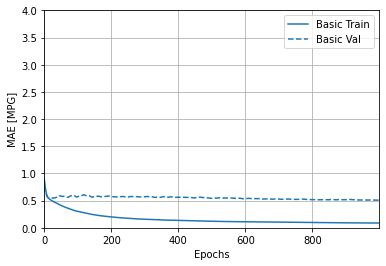

In [16]:
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 4])
plt.ylabel('MAE [MPG]')

In [17]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:4.1685,  mae:1.5190,  mse:4.1685,  val_loss:1.7433,  val_mae:0.9911,  val_mse:1.7433,  
........................

In [18]:
hist = pd.DataFrame(early_history.history)
hist['epoch'] = early_history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
19,0.412373,0.497854,0.412373,0.520103,0.554672,0.520103,19
20,0.411949,0.498708,0.411949,0.516218,0.554880,0.516218,20
21,0.406083,0.498891,0.406083,0.518844,0.548525,0.518844,21
22,0.394715,0.489057,0.394715,0.500363,0.536464,0.500363,22
23,0.401167,0.492464,0.401167,0.515003,0.547964,0.515003,23


Text(0, 0.5, 'MAE [MPG]')

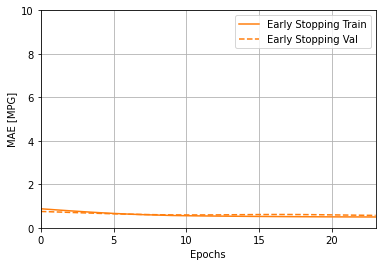

In [19]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

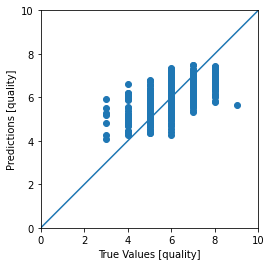

In [20]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [quality]')
plt.ylabel('Predictions [quality]')
lims = [0, 10]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
